In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
from IPython import display


# Building Block Networks

In [2]:
class Linear(Layer):
    def __init__(self, o_dim, use_bias=True):
        super(Linear, self).__init__()
        self.o_dim = o_dim
        self.use_bias = use_bias

    def build(self, input_shape):
        i_dim = input_shape[-1]
        o_dim = self.o_dim
        self.w = self.add_weight(shape=(i_dim, o_dim), initializer='random_normal', trainable=True)
        if self.use_bias:
            self.b = self.add_weight(shape=(o_dim,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        W = self.w
        if self.use_bias:
            B = self.b

        if self.use_bias:
            return tf.matmul(inputs, W) + B
        else:
            return tf.matmul(inputs, W)


In [3]:
class Conv2D(Layer):
    #This Conv2D has a singular constant added to each output channel
    #The kernel is applied over all channels to create each output channel and repeated output channel number of times
    def __init__(self, o_dim, ker_n, padding='SAME', stride=1):
        super(Conv2D, self).__init__()
        self.o_dim = o_dim
        self.padding = padding
        self.ker_n = ker_n
        self.stride = stride

    def build(self, input_shape):
        #depends what you feed but would like to stucture it
        #input_shape = [b,n,n,c]
        m,n,i_dim = input_shape[1:]
        o_dim = self.o_dim
        k_n = self.ker_n
        #[height, width, in_channels, out_channels]
        self.K = self.add_weight(shape=(k_n,k_n,i_dim,o_dim), initializer='random_normal', trainable=True)
        self.B = self.add_weight(shape=(o_dim,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        S = self.stride
        K = self.K
        B = self.B
        padding = self.padding
        x = tf.nn.conv2d(inputs, K, strides=S, padding=padding)
        x = tf.nn.bias_add(x, B)
        return x

In [4]:
class UpConv2D(Layer):
    def __init__(self, o_dim, stride,padding='SAME', ker_n = 3, use_bias=True):
        super(UpConv2D, self).__init__()
        self.o_dim = o_dim
        self.padding = padding
        self.stride = stride
        self.kernel_n = ker_n
        self.use_bias = use_bias

    def build(self, input_shape):
        #depends what you feed but would like to stucture it
        #input_shape = [b,n,n,c]
        k = self.kernel_n
        m,n,i_dim = input_shape[1:]
        o_dim = self.o_dim
        #[height, width, output_channels, in_channels]

        self.K = self.add_weight(shape=(k,k,o_dim, i_dim), initializer='glorot_uniform', trainable=True)
        if self.use_bias:
            self.B = self.add_weight(shape=(o_dim,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        K = self.K
        if self.use_bias:
            B = self.B

        padding = self.padding
        o_dim = self.o_dim
        b = inputs.shape[0]
        H = inputs.shape[1] # Assuming input shape is [b,n,n,c]
        S = self.stride

        # UpConv Output H=Input S=Stride K=Kernel
        # If padding is VALID: (H-1)*S + K
        # If padding is SAME:  H*S
        x = tf.nn.conv2d_transpose(inputs, K, output_shape=(b,H*S,H*S,o_dim) ,strides=S, padding='SAME')
        if self.use_bias:
            x = tf.nn.bias_add(x,B)
        return x


# Network Construction

In [5]:
class Discriminator(Layer):
    def __init__(self, o_dim):
        super(Discriminator, self).__init__()
        self.o_dim = o_dim
        self.cv1 = Conv2D(64, ker_n=5, stride=2)
        self.cv2 = Conv2D(128, ker_n=5, stride=2)
        self.lin1 = Linear(o_dim)
    def call(self, inputs):
        b = inputs.shape[0]
        x = self.cv1(inputs)
        x = tf.nn.leaky_relu(x)
        x = tf.nn.dropout(x, rate=.3)
        x = self.cv2(x)
        x = tf.nn.leaky_relu(x)
        x = tf.nn.dropout(x, rate=.3)
        x = tf.reshape(x,shape=(b,-1))
        x = self.lin1(x)
        return x


In [6]:
class Generator(Layer):

    def __init__(self ):
        super(Generator, self).__init__()
        self.lin1 = Linear(7*7*256, use_bias=False)
        self.upconv1 = UpConv2D(128,stride=1,ker_n=5, use_bias=False)
        self.upconv2 = UpConv2D(64,stride=2,ker_n=5, use_bias=False)
        self.upconv3 = UpConv2D(1,stride=2,ker_n=5, use_bias=False)
        
    def call(self, inputs):
        var_ep = .0000000001

        x = self.lin1(inputs)
        b_mean, b_var = tf.nn.moments(x, [0])
        x = tf.nn.batch_normalization(x, b_mean, b_var, offset=None, scale=None, variance_epsilon=var_ep)
        x = tf.nn.leaky_relu(x)

        x = tf.reshape(x, shape=(-1,7,7,256))

        x = self.upconv1(x)
        b_mean, b_var = tf.nn.moments(x, [0,1,2])
        x = tf.nn.batch_normalization(x, b_mean, b_var, offset=None, scale=None, variance_epsilon=var_ep)
        x = tf.nn.leaky_relu(x)

        x = self.upconv2(x)
        b_mean, b_var = tf.nn.moments(x, [0,1,2])
        x = tf.nn.batch_normalization(x, b_mean, b_var, offset=None, scale=None, variance_epsilon=var_ep)
        x = tf.nn.leaky_relu(x)

        x = self.upconv3(x)
        x = tf.nn.tanh(x)
        return x

# Training

In [9]:
def display_images(images):
    images = images.numpy().reshape(16,28,28)
    plt.figure(figsize=(12,12))
    f, axarr = plt.subplots(4,4)
    for i in range(4):
        for j in range(4):
            axarr[i,j].imshow(images[4*i+j]*127.5+127.5)
    plt.show()

def train_gan():
    (x_trn,y_trn), _ = tf.keras.datasets.mnist.load_data()
    x_trn = x_trn.reshape(60000, 28, 28, 1).astype('float32')
    x_trn = (x_trn- 127.5) / 127.5 # Normalize the images to [-1, 1]
    dataset = tf.data.Dataset.from_tensor_slices( (x_trn, y_trn) )

    def disc_loss(real_images, fake_images):
        R = len(real_images)
        F = len(fake_images)
        disc_loss = tf.keras.losses.binary_crossentropy(tf.ones_like( (real_images) ), real_images, from_logits=True)
        gen_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like( (fake_images) ), fake_images, from_logits=True)
        return disc_loss + gen_loss

    def gen_loss(fake_images):
        F = len(fake_images)
        gen_loss = tf.keras.losses.binary_crossentropy(tf.ones_like( fake_images ), fake_images, from_logits=True)
        return gen_loss


    generator = Generator()
    discriminator = Discriminator(o_dim=1)
    g_optimizer = tf.keras.optimizers.Adam(1e-4)
    d_optimizer = tf.keras.optimizers.Adam(1e-4)


    @tf.function
    def train_batch(x):
        b,_,_,_ = x.shape
        noise = tf.random.normal((b,100))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            gen_images = generator(noise)
            real_disc = discriminator(x)
            fake_disc = discriminator(gen_images)

            d_loss = disc_loss(real_disc, fake_disc)
            g_loss = gen_loss(fake_disc)

        d_gradients = disc_tape.gradient(d_loss, discriminator.trainable_weights)
        g_gradients = gen_tape.gradient(g_loss, generator.trainable_weights)

        d_optimizer.apply_gradients( zip(d_gradients, discriminator.trainable_weights) )
        g_optimizer.apply_gradients( zip(g_gradients, generator.trainable_weights) )

        return d_loss, g_loss
    
    
    b = 256
    test_examples = tf.random.normal((16,100))
    batches = dataset.shuffle(buffer_size=60000).batch(b)
    
    for i in range(50):    
        for step,(x,y) in enumerate(batches):
            d_loss, g_loss = train_batch(x)
        test_images = generator(test_examples)
        display_images(test_images)
        print('Epoch', i+1)

<Figure size 864x864 with 0 Axes>

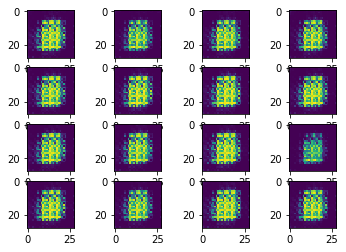

Epoch 1


<Figure size 864x864 with 0 Axes>

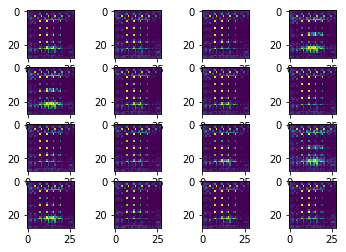

Epoch 2


<Figure size 864x864 with 0 Axes>

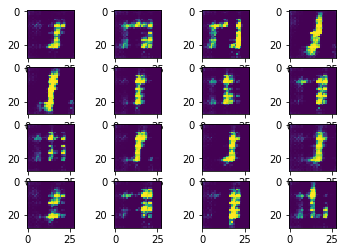

Epoch 3


<Figure size 864x864 with 0 Axes>

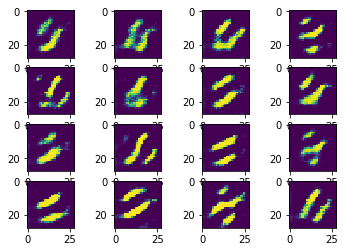

Epoch 4


<Figure size 864x864 with 0 Axes>

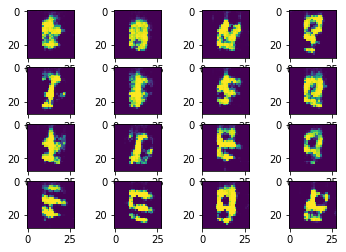

Epoch 5


<Figure size 864x864 with 0 Axes>

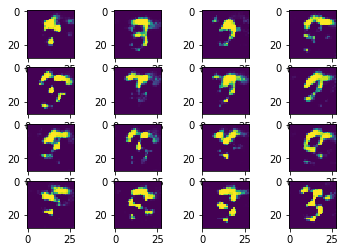

Epoch 6


<Figure size 864x864 with 0 Axes>

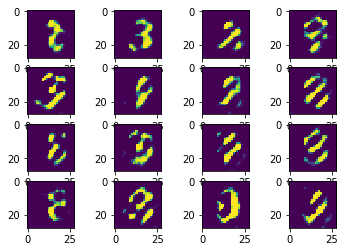

Epoch 7


<Figure size 864x864 with 0 Axes>

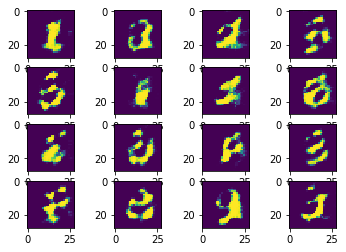

Epoch 8


<Figure size 864x864 with 0 Axes>

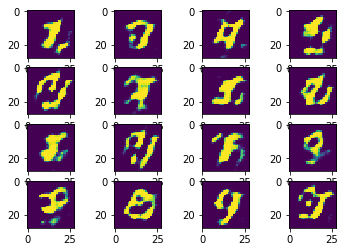

Epoch 9


<Figure size 864x864 with 0 Axes>

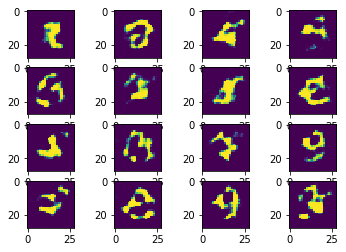

Epoch 10


<Figure size 864x864 with 0 Axes>

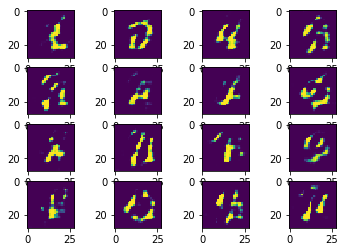

Epoch 11


<Figure size 864x864 with 0 Axes>

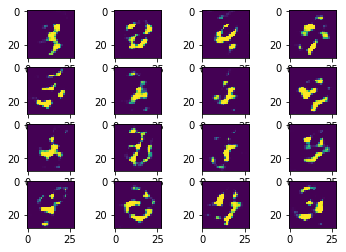

Epoch 12


<Figure size 864x864 with 0 Axes>

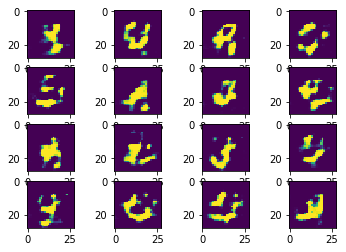

Epoch 13


<Figure size 864x864 with 0 Axes>

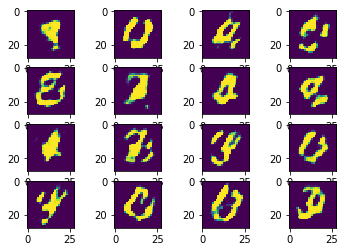

Epoch 14


<Figure size 864x864 with 0 Axes>

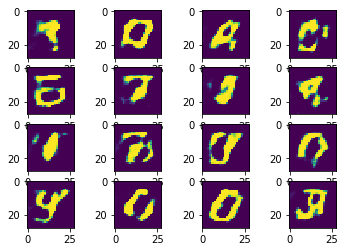

Epoch 15


<Figure size 864x864 with 0 Axes>

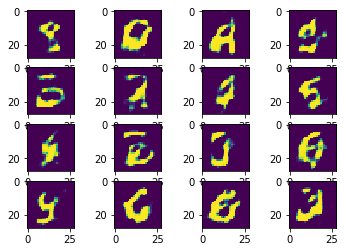

Epoch 16


<Figure size 864x864 with 0 Axes>

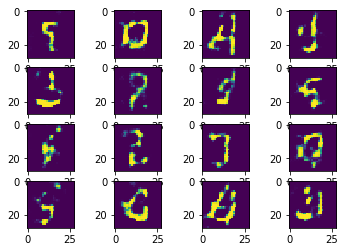

Epoch 17


<Figure size 864x864 with 0 Axes>

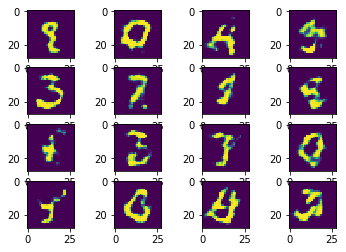

Epoch 18


<Figure size 864x864 with 0 Axes>

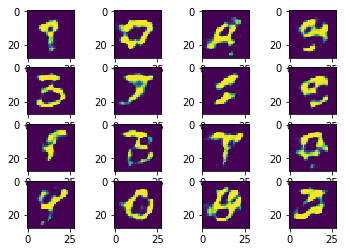

Epoch 19


<Figure size 864x864 with 0 Axes>

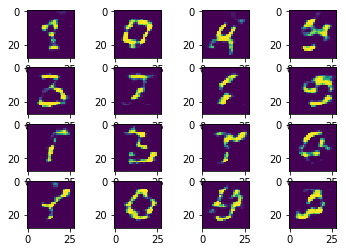

Epoch 20


<Figure size 864x864 with 0 Axes>

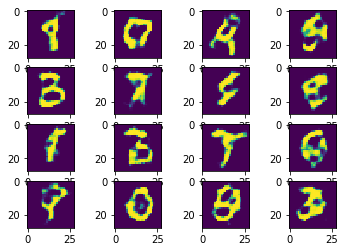

Epoch 21


<Figure size 864x864 with 0 Axes>

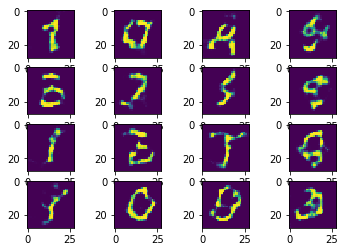

Epoch 22


<Figure size 864x864 with 0 Axes>

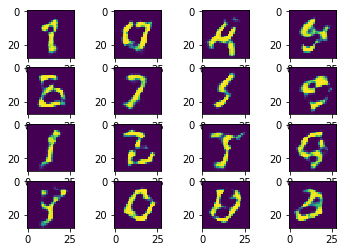

Epoch 23


<Figure size 864x864 with 0 Axes>

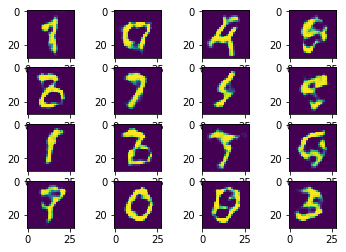

Epoch 24


<Figure size 864x864 with 0 Axes>

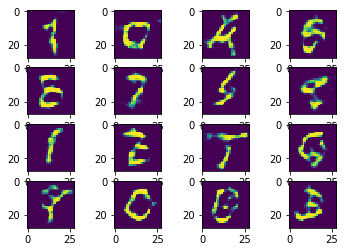

Epoch 25


<Figure size 864x864 with 0 Axes>

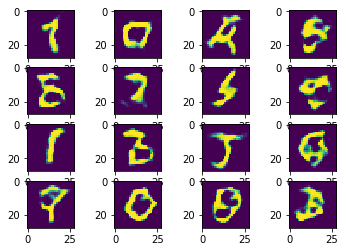

Epoch 26


<Figure size 864x864 with 0 Axes>

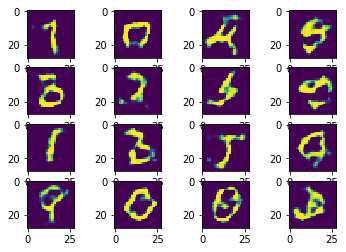

Epoch 27


<Figure size 864x864 with 0 Axes>

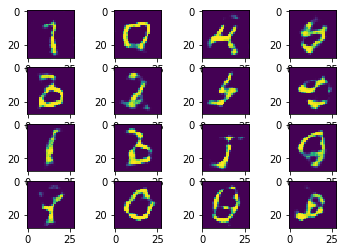

Epoch 28


<Figure size 864x864 with 0 Axes>

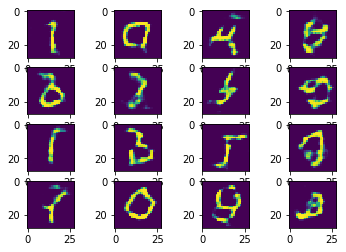

Epoch 29


<Figure size 864x864 with 0 Axes>

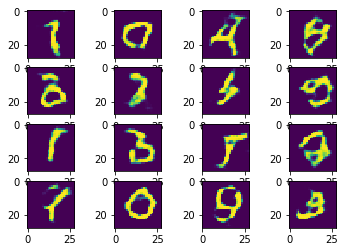

Epoch 30


In [10]:
train_gan()